In [4]:
import src.data_processing.load_data as load_data
import src.data_processing.prediction_processing as predprocess
import src.models.LGBM_sleepy_score as sscore
import src.models.ensemble as ensemble
import src.models.SARIMAX as SARIMAXfc
import numpy as np
import pandas as pd
import os
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

import matplotlib.pyplot as plt

In [ ]:
#load baby's data
sleep, time0 = load_data.get_sleep('12/06/2021', 'data/')

In [7]:
time0 = time0 + pd.DateOffset(days = 100)

In [8]:
weights = np.array([1, 1, 1])
conv = np.array([1, 1, 2, 4, 6, 4, 2, 1, 1])
conv = conv / conv.sum()

# define needed variables
forecast_period = 1 * 24 * 6 + 30
DATA_PATH = 'data/'
MODEL_PATH = 'src/models/'

In [ ]:
SARIMAXfc.model_update(sleep, time0, MODEL_PATH)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94419D-01    |proj g|=  7.07340D-01


 This problem is unconstrained.



At iterate    5    f=  2.61881D-01    |proj g|=  3.95846D-02

At iterate   10    f=  2.17003D-01    |proj g|=  1.05516D-01

At iterate   15    f=  2.15382D-01    |proj g|=  8.11283D-03

At iterate   20    f=  2.14246D-01    |proj g|=  4.48098D-03

At iterate   25    f=  2.13992D-01    |proj g|=  6.33631D-03

At iterate   30    f=  2.13677D-01    |proj g|=  2.17280D-03

At iterate   35    f=  2.13621D-01    |proj g|=  1.40562D-02

At iterate   40    f=  2.13606D-01    |proj g|=  9.99377D-04

At iterate   45    f=  2.13604D-01    |proj g|=  6.99637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     45     63   

In [10]:
timeseries = (sleep.sleep - sleep.trend)[-10 * 24 * 6 - 12 * 6 :]

In [ ]:
fc3 = SARIMAXfc.forecast(sleep, time0, DATA_PATH, MODEL_PATH, forecast_period)

In [11]:
#load the latest fitted model
res = SARIMAXResults.load(os.path.join(MODEL_PATH, 'saved_models/SARIMAX.pkl'))

In [ ]:
res.summary()

In [13]:
#update model with the new data
file = open(os.path.join(MODEL_PATH, 'saved_models/SARIMAX_time.txt'), 'r')
last_time = pd.Timestamp(file.read())
timeseries0 = timeseries[timeseries.index > last_time]

In [32]:
timeseries[-498-64:-498]

2000-04-15 16:20:00    0.727273
2000-04-15 16:30:00    0.727273
2000-04-15 16:40:00   -0.265152
2000-04-15 16:50:00   -0.257576
2000-04-15 17:00:00   -0.257576
                         ...   
2000-04-16 02:10:00    0.053030
2000-04-16 02:20:00    0.045455
2000-04-16 02:30:00   -0.924242
2000-04-16 02:40:00   -0.901515
2000-04-16 02:50:00    0.090909
Freq: 10T, Length: 64, dtype: float64

In [27]:
timeseries0[:10]

2000-04-16 01:20:00    0.083333
2000-04-16 01:30:00    0.075758
2000-04-16 01:40:00    0.090909
2000-04-16 01:50:00    0.083333
2000-04-16 02:00:00    0.053030
2000-04-16 02:10:00    0.053030
2000-04-16 02:20:00    0.045455
2000-04-16 02:30:00   -0.924242
2000-04-16 02:40:00   -0.901515
2000-04-16 02:50:00    0.090909
Freq: 10T, dtype: float64

In [ ]:
res = res.append(timeseries0[20:])

In [19]:
#get the forecast
forecast = res.get_forecast(steps = forecast_period)

<AxesSubplot:>

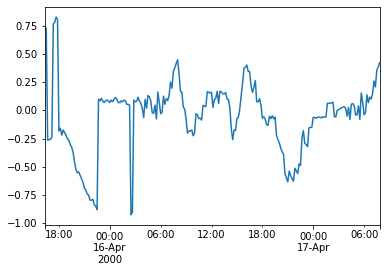

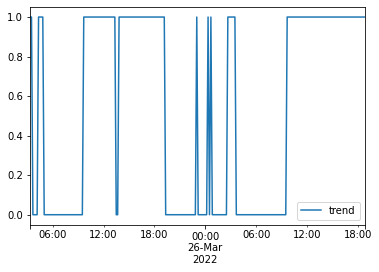

In [34]:
prediction = pd.Series(forecast.predicted_mean)
answer = pd.concat([timeseries[-498-64:-498],prediction])
answer.plot()
answer = pd.DataFrame(answer, columns=['trend'])

trend = pd.read_csv(os.path.join(DATA_PATH, 'NYU_data_processed/NYU_trend.csv'), parse_dates=['timestamps'], index_col= 'timestamps')
addtrend = pd.DataFrame(trend.trend[answer.index[0]:answer.index[-1]])

answer = answer + addtrend
answer.trend = (answer.trend > 0.5).astype(int)
answer.index += time0 - answer.index[63]
answer.plot()

<AxesSubplot:>

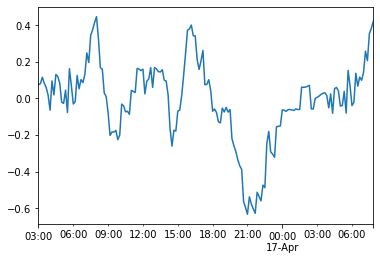

In [25]:
forecast.predicted_mean.plot()

In [ ]:
ans, pred1, pred2, pred3 = ensemble.forecast(sleep, time0, DATA_PATH, MODEL_PATH,
                                      forecast_period, weights, conv, conv)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))
ans.plot(ax = ax)
hrs_begin = ans.index[0].ceil(freq='1h')
hrs_end = ans.index[-1].floor(freq='1h')
allhrs = pd.date_range(start = hrs_begin, end = hrs_end, freq = '1h')
plt.vlines(x=allhrs, ymin=-0.01, ymax=1.0, colors='gray', alpha = 0.25)
plt.fill_between(x = ans.index, y1 = ans.trend, alpha = 0.25)
plt.yticks([])
plt.text(-0.05,0.95,'Sleeping',horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes)
plt.text(-0.05,0.05,'Awake',horizontalalignment='center',
             verticalalignment='center', transform = ax.transAxes)
ax.get_legend().remove()
plt.show()